In [1]:
%matplotlib inline

import colorsys
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scikits.bootstrap
from scipy.optimize import curve_fit

cb_col = np.array([[228,26,28],
                   [55,126,184],
                   [77,175,74],
                   [152,78,163],
                   [255,127,0],
                   [255,255,51],])/255
symbols = 'osHD'

ar_colors = {}
ar_colors['any_worse', 'monoar'] = np.array([228,26,28])/255.0
ar_colors['strongly_worse', 'monoar'] = np.array([99, 41, 42])/255.0
ar_colors['any_worse', 'binoar'] = np.array([55,126,184])/255.0
ar_colors['strongly_worse', 'binoar'] = np.array([40, 91, 133])/255.0

In [2]:
# Load the user data
luna_df = pd.read_csv('perceptual_data.csv')
luna_df['nonuniformity'] = (100-luna_df['uniformity'])/(100+luna_df['uniformity'])
luna_df['strongly_worse'] = (luna_df['convresp'] >= 2)
luna_df['any_worse'] = (luna_df['convresp'] >= 1)

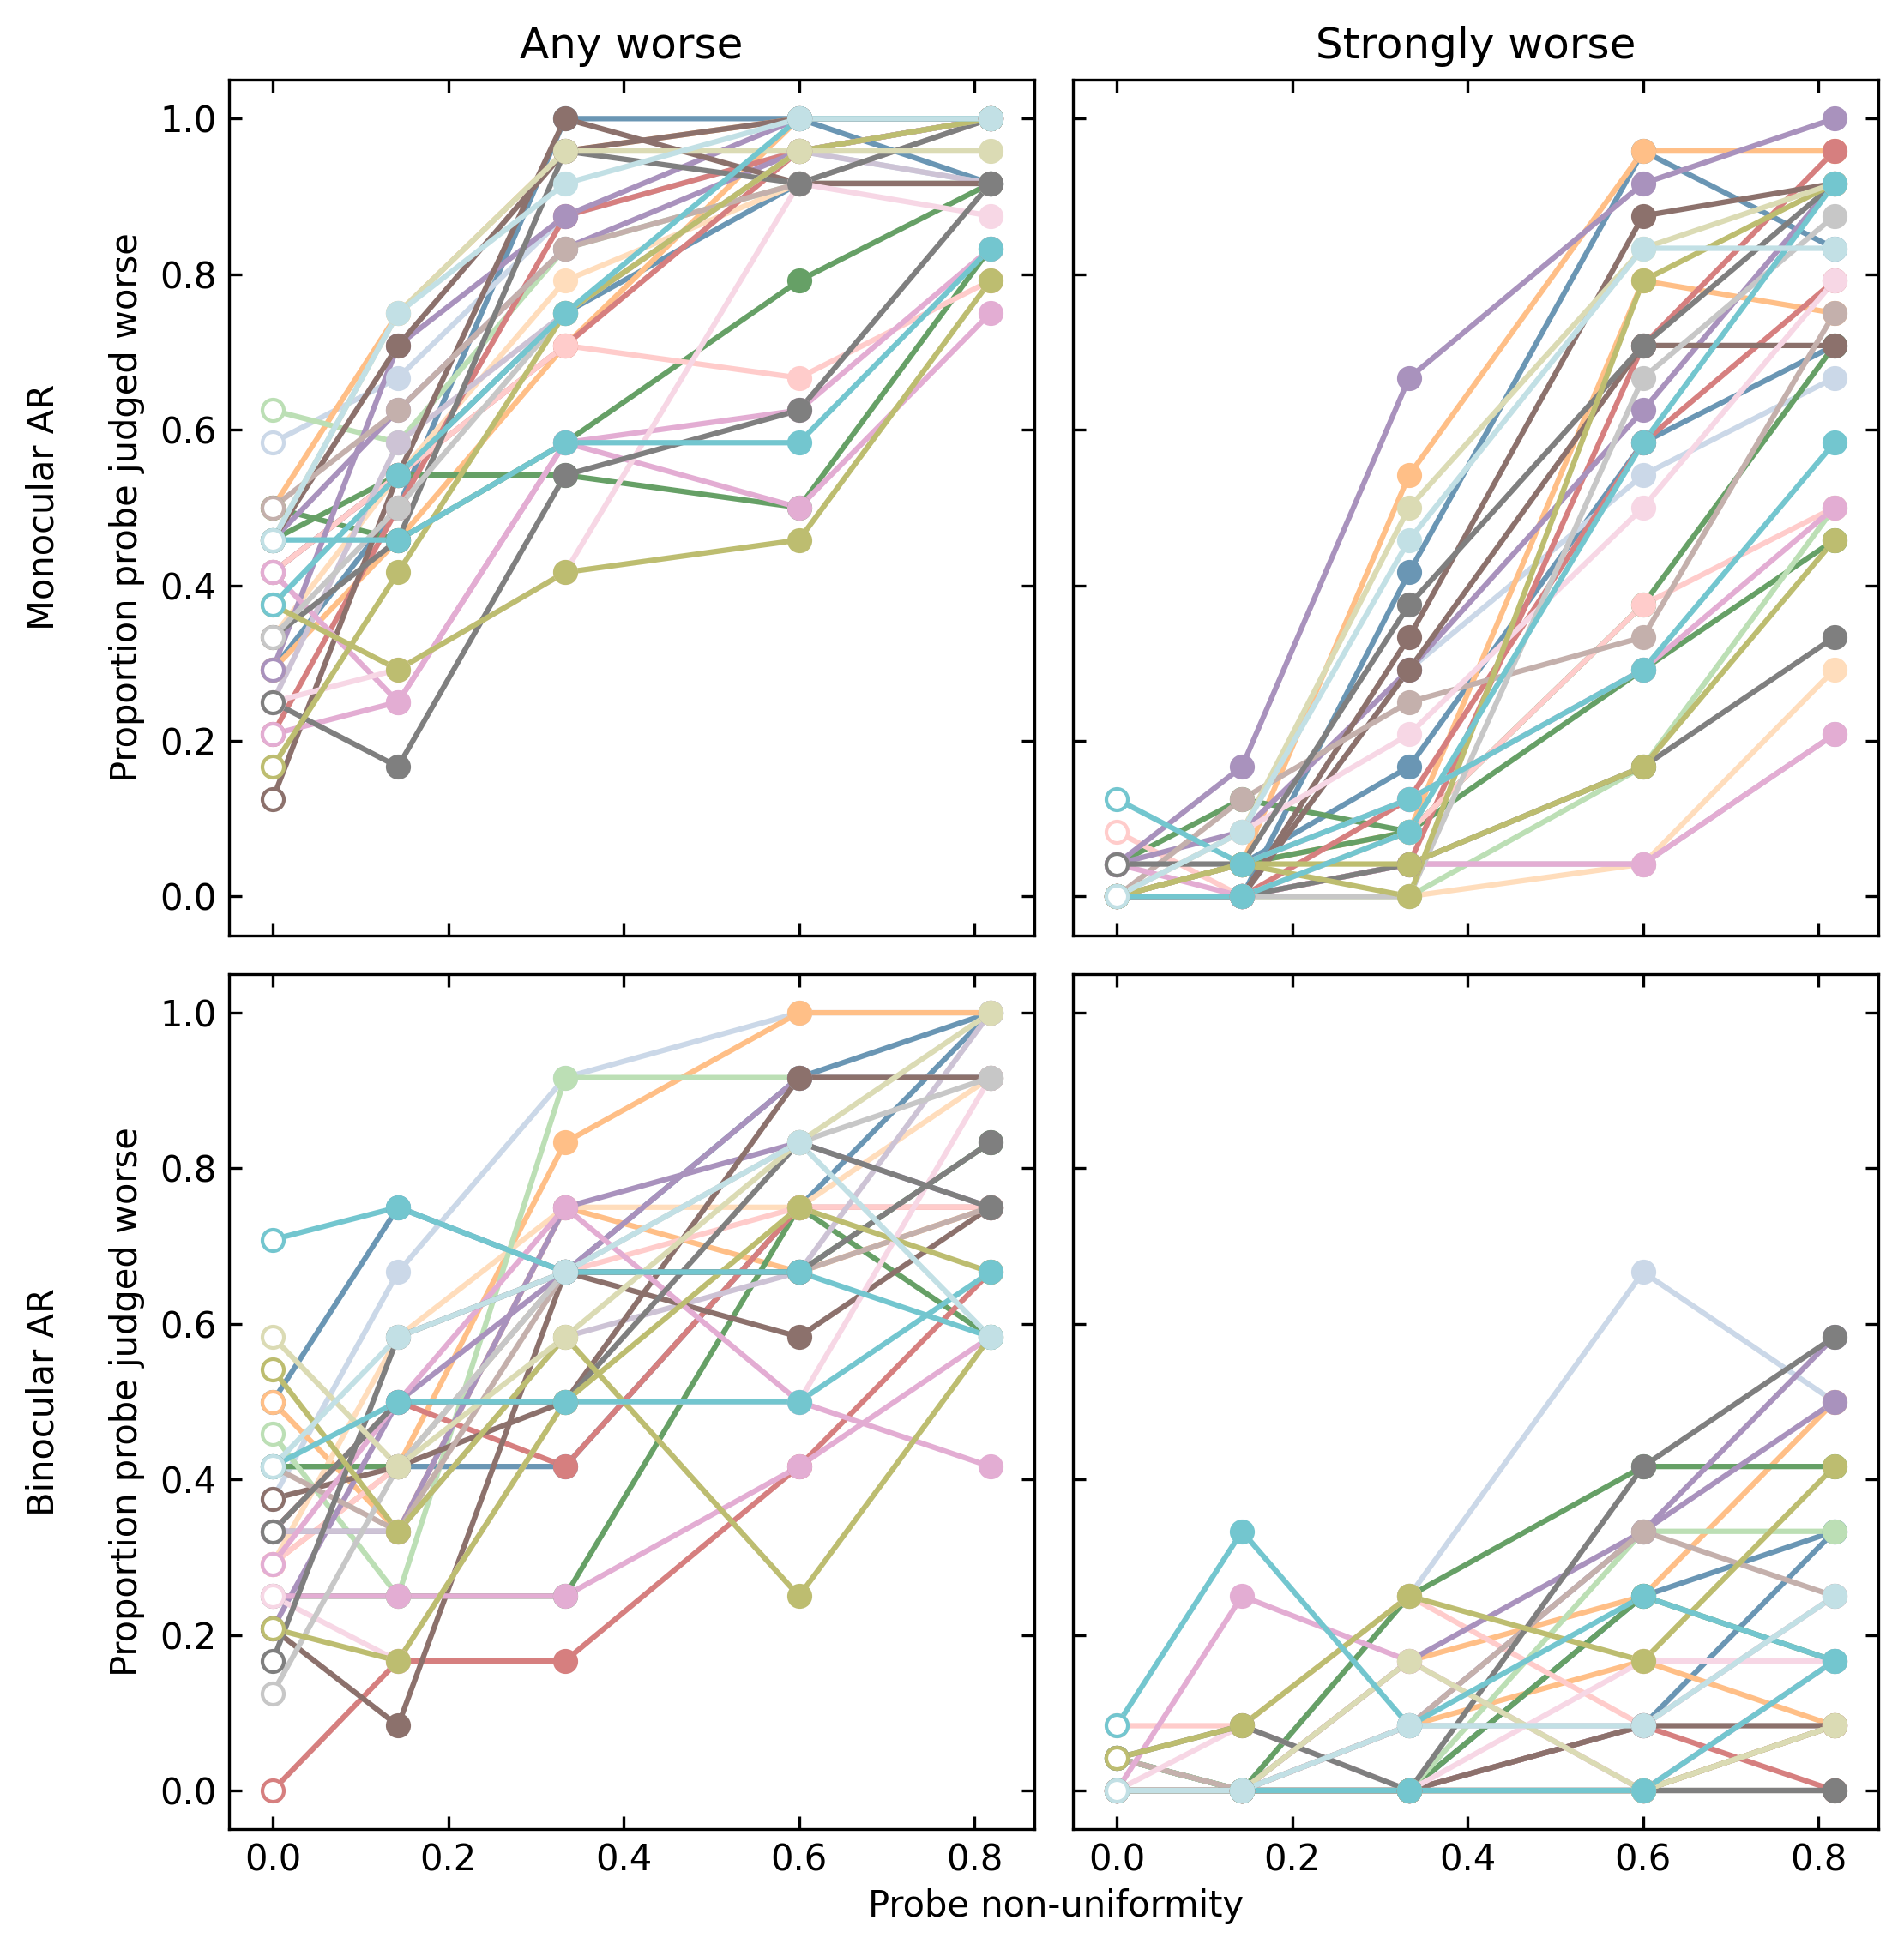

In [3]:
#Figure 11
f, ax = plt.subplots(2, 2, figsize=(7.5, 7.5), dpi=300)

for crit_idx, crit in enumerate(['any_worse', 'strongly_worse']):
    # Plot individual data
    df = luna_df.groupby(['subject', 'AR', 'luning', 'nonuniformity']).mean().sort_values(by=['nonuniformity']).reset_index()

    # Setup colors
    cmap_ind = matplotlib.colors.Normalize(vmin=0, vmax=len(set(df.subject)))

    fits_ind = {}
    for subject_idx, subject in enumerate(set(df.subject)):
        for (AR, luning) in (('monoar', 'monolune'),
                             ('binoar', 'binolune')):
            AR_idx = ['monoar', 'binoar'].index(AR)
            
            df_subset = df.loc[(df.subject == subject) & (df.AR == AR) &
                               ((df.luning == luning) | (df.luning == 'nolune'))]

            x = df_subset['nonuniformity'].to_list()
            y = df_subset[crit].to_list()

            # Get the line/marker color
            color = plt.get_cmap('tab20')(cmap_ind(subject_idx))
            # Reduce color saturation
            color = np.array(colorsys.rgb_to_hsv(*color[:3]))
            color[1] = color[1]*0.5
            color = colorsys.hsv_to_rgb(*color)
            # Plot the line
            ax[AR_idx, crit_idx].plot(x, y, '-', color=color, zorder=-10)
            # Plot the markers
            for idx in range(len(x)):
                if idx == 0:
                    facecolor = 'w'
                else:
                    facecolor = color
                ax[AR_idx, crit_idx].plot(x[idx], y[idx], 'o', color=color, markerfacecolor=facecolor, zorder=10)

# Formatting
for a in ax.flatten():
    a.set_xlim([-0.05, max(df_subset['nonuniformity'])+0.05])
    a.set_ylim([-0.05, 1.05])
    a.tick_params(direction='in', bottom=True, top=True, left=True, right=True)
    
ax[0,0].set_title('Any worse')
ax[0,0].set_ylabel('Monocular AR\n\nProportion probe judged worse')
ax[0,0].set_xticklabels([])
ax[0,1].set_title('Strongly worse')
ax[0,1].set_yticklabels([])
ax[0,1].set_xticklabels([])
ax[1,0].set_ylabel('Binocular AR\n\nProportion probe judged worse')
ax[1,1].set_yticklabels([])


f.text(0.554, 0, 'Probe non-uniformity', ha='center')
    
plt.tight_layout()
plt.show()

In [4]:
# Calculate averages for the different conditions
df = luna_df.groupby(['subject', 'AR', 'luning', 'nonuniformity']).mean().sort_values(by=['nonuniformity']).reset_index()
    
x = {}
y = {}
ci = {}
for criterion in ['strongly_worse', 'any_worse']:
    for AR, luning in (('monoar', 'monolune'),
                       ('binoar', 'binolune')):
        df_subset = df.loc[(df['AR'] == AR) & ((df['luning'] == luning) | (df['luning'] == 'nolune'))]

        x[criterion, AR], y[criterion, AR], ci[criterion, AR] = [], [], []
        for n_idx, n in enumerate(sorted(set(df_subset['nonuniformity']))):
            dat = df_subset[df_subset['nonuniformity']==n][criterion]
            x[criterion, AR].append(n)
            y[criterion, AR].append(dat.mean())
            ci[criterion, AR].append(scikits.bootstrap.ci(dat))

In [5]:
# Gaussian CDF fit, which will be fit to the user data
def cdf_2param(x, mu, sigma):
    return 1/2*(1+math.erf((x-mu)/(sigma*np.sqrt(2))))
cdf_v = np.vectorize(cdf_2param)

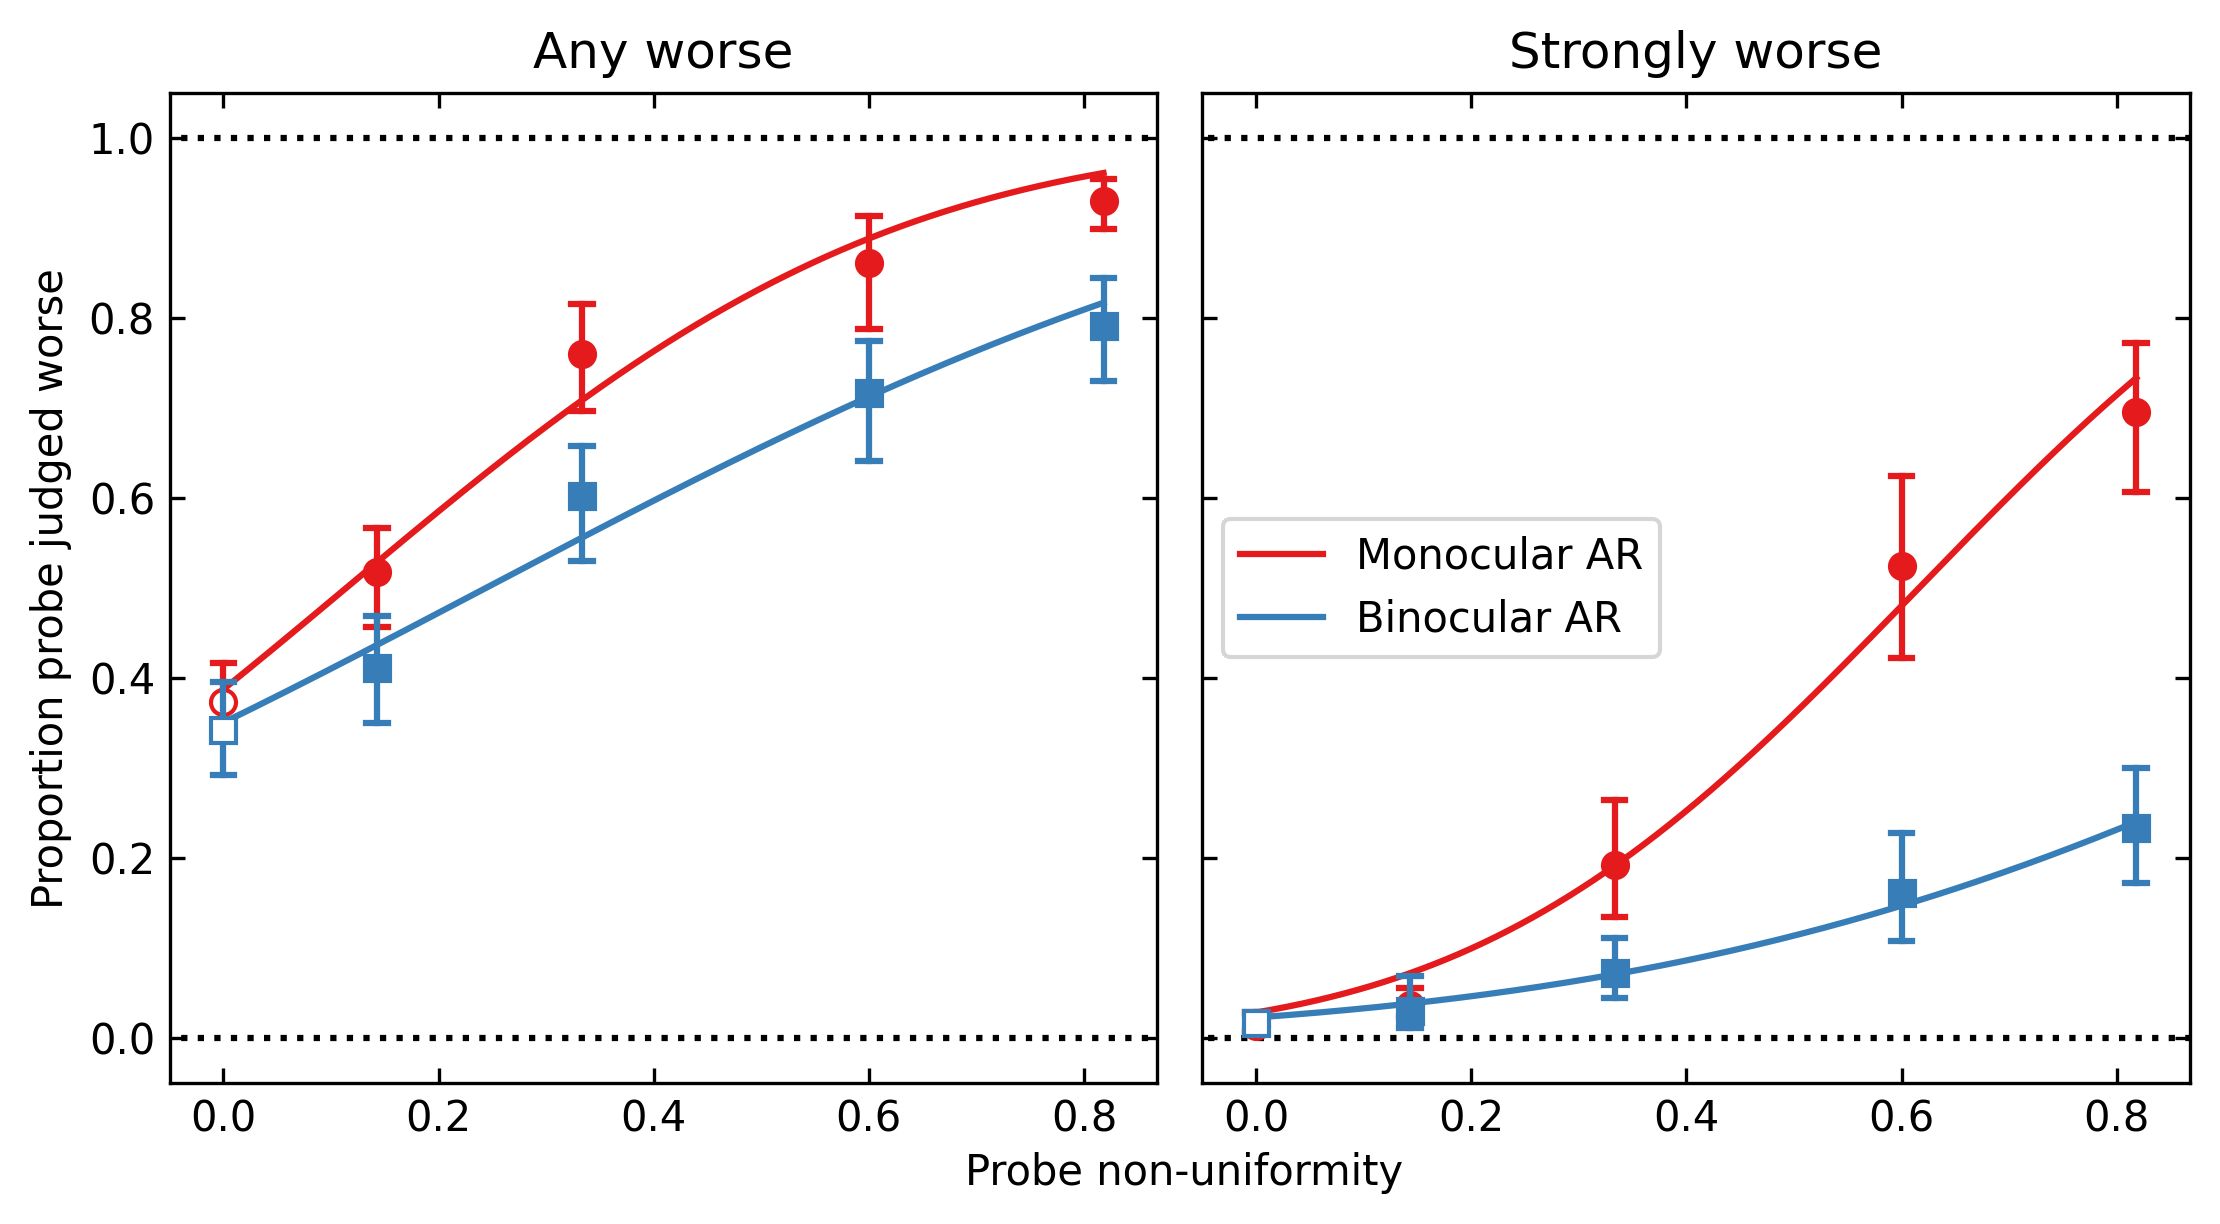

In [6]:
# Figure 9
f, ax = plt.subplots(1, 2, figsize=(7.5,4), dpi=300)

for a in ax:
    a.plot([-100, 100], [0, 0], 'k:', zorder=-1)
    a.plot([-100, 100], [1, 1], 'k:', zorder=-1)

fits_mean = {}
for a_idx, a in enumerate(ax):
    crit = ['any_worse', 'strongly_worse'][a_idx]
    
    # Plot monocular fits
    t = np.linspace(min(x[crit, 'monoar']), max(x[crit, 'monoar']), 1000)
    fit_params = curve_fit(cdf_v, x[crit, 'monoar'],
                                  y[crit, 'monoar'], p0=[0.5, 2])[0]
    fits_mean[crit, 'monoar'] = fit_params
    a.plot(t, cdf_v(t, *fit_params), '-', color=cb_col[0,], label='Monocular AR')
    
    # Plot binocular fits
    t = np.linspace(min(x[crit, 'binoar']), max(x[crit, 'binoar']), 1000)
    fit_params = curve_fit(cdf_v, x[crit, 'binoar'],
                                  y[crit, 'binoar'], p0=[0.5, 2])[0]
    fits_mean[crit, 'binoar'] = fit_params
    a.plot(t, cdf_v(t, *fit_params), '-', color=cb_col[1,], label='Binocular AR')
    
    for n in range(5):
        a.plot([x[crit, 'monoar'][n], x[crit, 'monoar'][n]],
               [ci[crit, 'monoar'][n][0], ci[crit, 'monoar'][n][1]], '-', color=cb_col[0,])
        a.plot([x[crit, 'monoar'][n]-0.01, x[crit, 'monoar'][n]+0.01],
               [ci[crit, 'monoar'][n][0], ci[crit, 'monoar'][n][0]], '-', color=cb_col[0,])
        a.plot([x[crit, 'monoar'][n]-0.01, x[crit, 'monoar'][n]+0.01],
               [ci[crit, 'monoar'][n][1], ci[crit, 'monoar'][n][1]], '-', color=cb_col[0,])
        if n == 0:
            a.plot(x[crit, 'monoar'][n], y[crit, 'monoar'][n], 'o', color=cb_col[0,], marker=symbols[0], markerfacecolor='w')
        else:
            a.plot(x[crit, 'monoar'][n], y[crit, 'monoar'][n], 'o', color=cb_col[0,], marker=symbols[0])
    for n in range(5):
        a.plot([x[crit, 'binoar'][n], x[crit, 'binoar'][n]],
               [ci[crit, 'binoar'][n][0], ci[crit, 'binoar'][n][1]], '-', color=cb_col[1,])
        a.plot([x[crit, 'binoar'][n]-0.01, x[crit, 'binoar'][n]+0.01],
               [ci[crit, 'binoar'][n][0], ci[crit, 'binoar'][n][0]], '-', color=cb_col[1,])
        a.plot([x[crit, 'binoar'][n]-0.01, x[crit, 'binoar'][n]+0.01],
               [ci[crit, 'binoar'][n][1], ci[crit, 'binoar'][n][1]], '-', color=cb_col[1,])
        if n == 0:
            a.plot(x[crit, 'binoar'][n], y[crit, 'binoar'][n], 'o', color=cb_col[1,], marker=symbols[1], markerfacecolor='w')
        else:
            a.plot(x[crit, 'binoar'][n], y[crit, 'binoar'][n], 'o', color=cb_col[1,], marker=symbols[1])

    # Formatting
    a.set_xlim([-0.05, max(df_subset['nonuniformity'])+0.05])
    a.set_ylim([-0.05, 1.05])
    a.tick_params(direction='in', bottom=True, top=True, left=True, right=True)
    if a_idx == 0:
        a.set_title('Any worse')
        a.set_ylabel('Proportion probe judged worse')
    elif a_idx == 1:
        a.set_title('Strongly worse')
        a.legend()
        a.set_yticklabels([])

f.text(0.533, 0, 'Probe non-uniformity', ha='center')

plt.tight_layout()
plt.show()

In [7]:
# Calculate averages for the different conditions
df = luna_df.copy()
    
x = {}
y = {}
ci = {}
for criterion in ['strongly_worse', 'any_worse']:
    for where in ('nasal', 'temporal'):
        for AR, luning in (('monoar', 'monolune'),
                           ('binoar', 'binolune')):
            df_subset = df.loc[(df['AR'] == AR) &
                               (((df['luning'] == luning) & (df['where'] == where)) |
                               ((df['luning'] == 'nolune') & (pd.isna(df['where']))))]

            x[criterion, where, AR], y[criterion, where, AR], ci[criterion, where, AR] = [], [], []
            for n_idx, n in enumerate(sorted(set(df_subset['nonuniformity']))):
                dat = df_subset[df_subset['nonuniformity']==n][criterion]
                x[criterion, where, AR].append(n)
                y[criterion, where, AR].append(dat.mean())
                ci[criterion, where, AR].append(scikits.bootstrap.ci(dat))

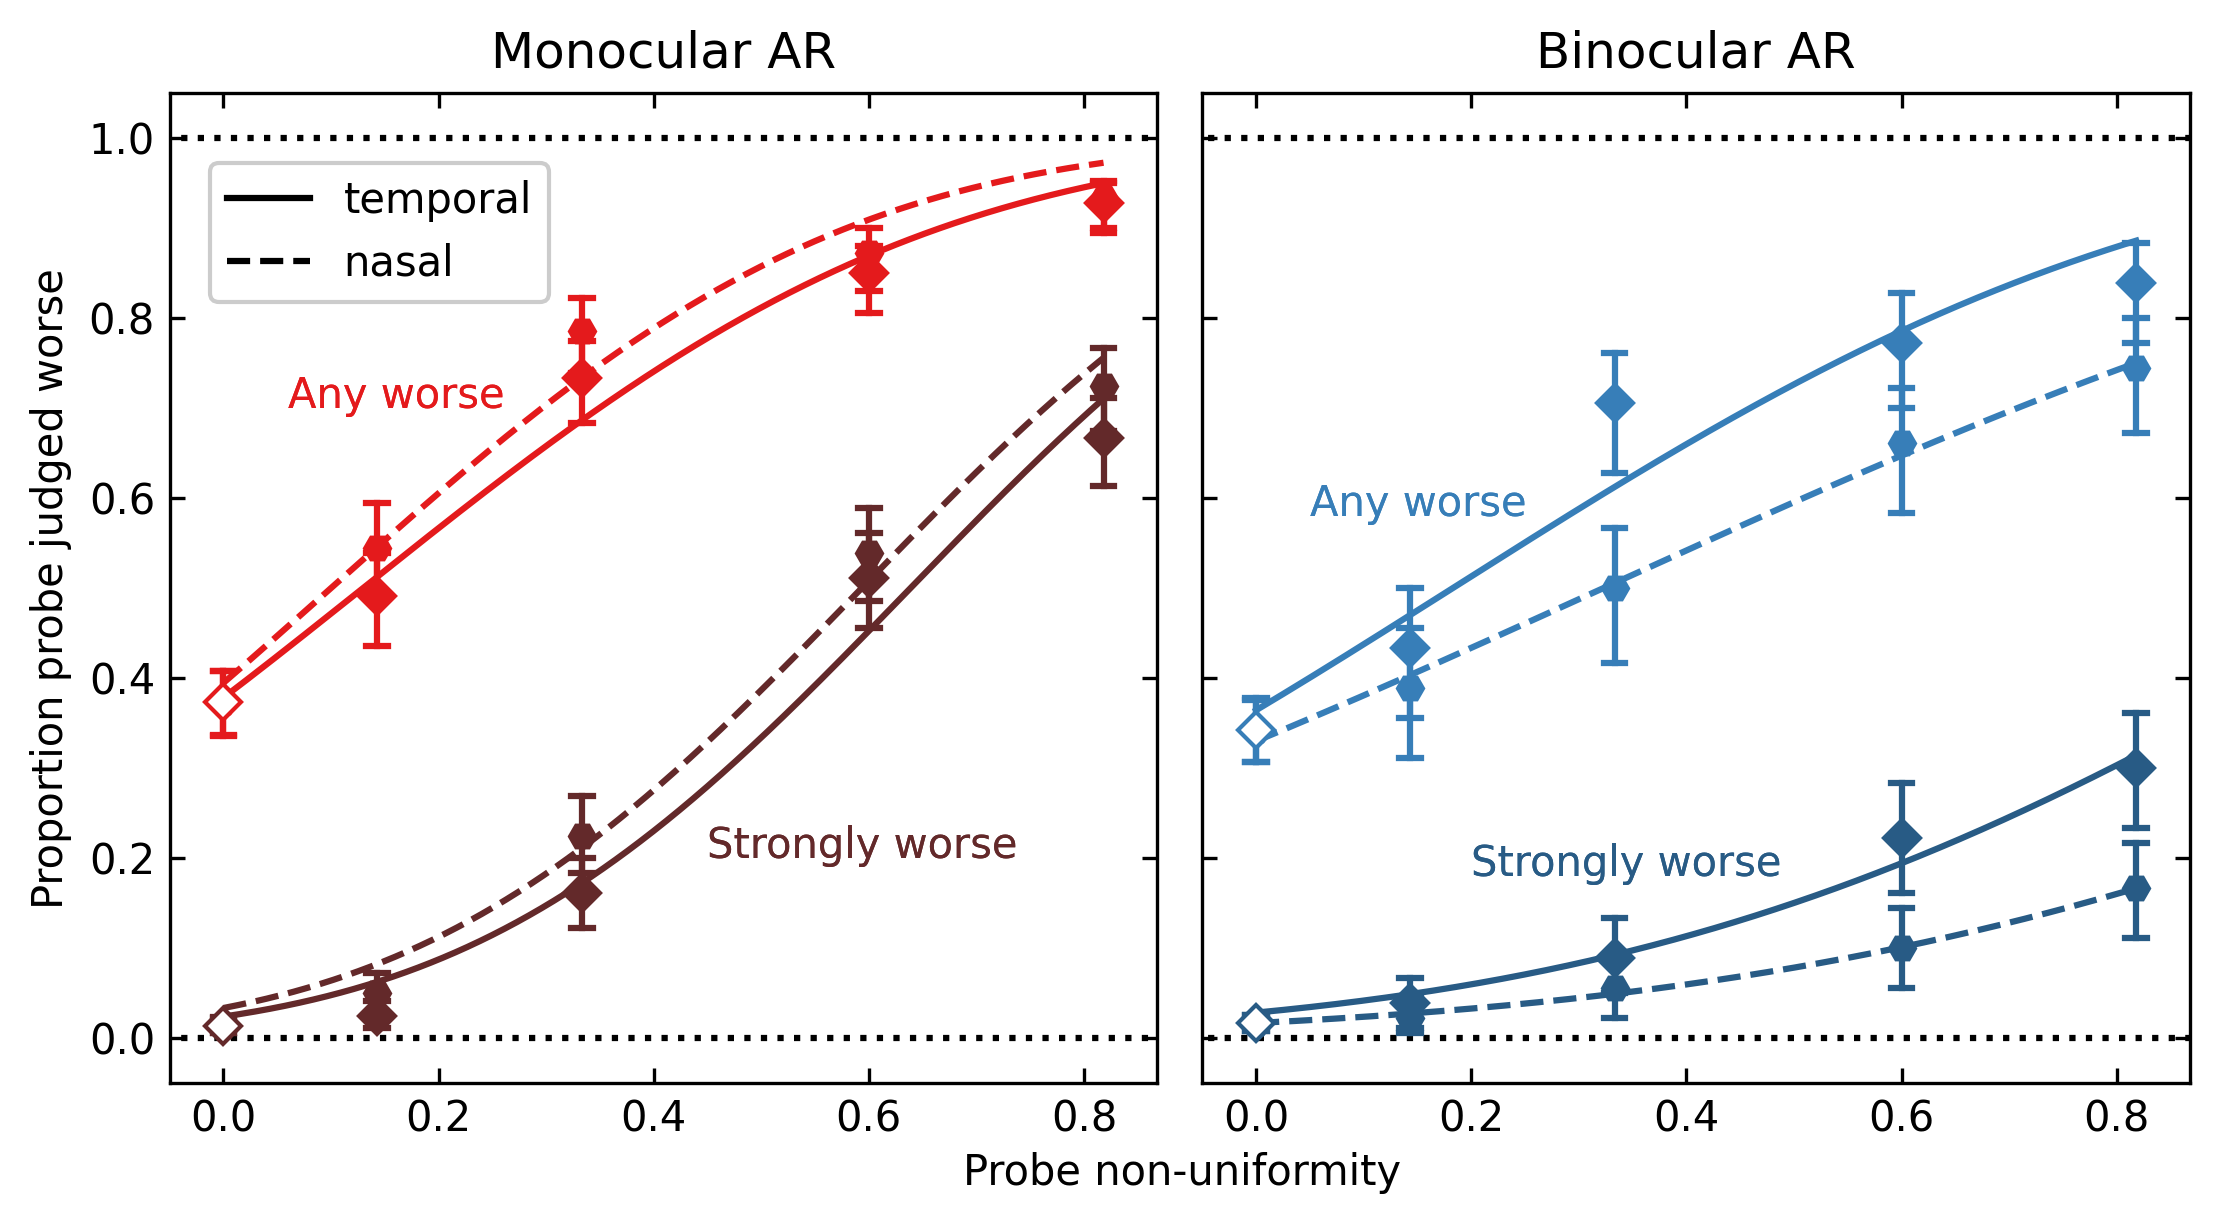

In [8]:
# Figure 12
f, ax = plt.subplots(1, 2, figsize=(7.5, 4), dpi=300)

for a in ax.flatten():
    a.plot([-100, 100], [0, 0], 'k:', zorder=-1)
    a.plot([-100, 100], [1, 1], 'k:', zorder=-1)

for crit_idx, crit in enumerate(['any_worse', 'strongly_worse']):
    for AR_idx, AR in enumerate(['monoar', 'binoar']):
        for where_idx, where in enumerate(['nasal', 'temporal']):            
            # Plot fits
            x_tmp = x[crit, where, AR]
            y_tmp = y[crit, where, AR]
            t = np.linspace(min(x_tmp), max(x_tmp), 1000)
            fit_params = curve_fit(cdf_v, x_tmp, y_tmp, p0=[0.5, 2])[0]
            
            if where == 'nasal':
                ax[AR_idx].plot(t, cdf_v(t, *fit_params), '--', color=ar_colors[crit, AR])
            elif where == 'temporal':
                ax[AR_idx].plot(t, cdf_v(t, *fit_params), '-', color=ar_colors[crit, AR])
            
            # Plot error bars
            for n in range(5):
                ax[AR_idx].plot(
                    [x[crit, where, AR][n], x[crit, where, AR][n]],
                    [ci[crit, where, AR][n][0], ci[crit, where, AR][n][1]], '-', color=ar_colors[crit, AR])
                ax[AR_idx].plot(
                    [x[crit, where, AR][n]-0.01, x[crit, where, AR][n]+0.01],
                    [ci[crit, where, AR][n][0], ci[crit, where, AR][n][0]], '-', color=ar_colors[crit, AR])
                ax[AR_idx].plot(
                    [x[crit, where, AR][n]-0.01, x[crit, where, AR][n]+0.01],
                    [ci[crit, where, AR][n][1], ci[crit, where, AR][n][1]], '-', color=ar_colors[crit, AR])
                if n == 0:
                    ax[AR_idx].plot(x[crit, where, AR][n],y[crit, where, AR][n],
                                              'o', color=ar_colors[crit, AR], marker=symbols[where_idx+2],
                                              markerfacecolor='w')
                else:
                    ax[AR_idx].plot(x[crit, where, AR][n], y[crit, where, AR][n],
                                              'o', color=ar_colors[crit, AR], marker=symbols[where_idx+2])
                    
            # Add some labels
            if (crit == 'strongly_worse') & (AR == 'monoar'):
                ax[AR_idx].text(0.45, 0.2, 'Strongly worse', color=ar_colors[crit, AR])
            elif (crit == 'any_worse') & (AR == 'monoar'):
                ax[AR_idx].text(0.06, 0.7, 'Any worse', color=ar_colors[crit, AR])
            elif (crit == 'strongly_worse') & (AR == 'binoar'):
                ax[AR_idx].text(0.2, 0.18, 'Strongly worse', color=ar_colors[crit, AR])
            elif (crit == 'any_worse') & (AR == 'binoar'):
                ax[AR_idx].text(0.05, 0.58, 'Any worse', color=ar_colors[crit, AR])

        # Formatting
        ax[AR_idx].set_xlim([-0.05, max(df_subset['nonuniformity'])+0.05])
        ax[AR_idx].set_ylim([-0.05, 1.05])
        ax[AR_idx].tick_params(direction='in', bottom=True, top=True, left=True, right=True)
        if (AR_idx == 0):
            ax[AR_idx].set_title('Monocular AR')
            ax[AR_idx].set_ylabel('Proportion probe judged worse')
        elif (AR_idx == 1):
            ax[AR_idx].set_title('Binocular AR')
            ax[AR_idx].set_yticklabels([])
            
        # Add the nasal/temporal legend
        if (AR_idx == 0) & (crit_idx == 0):
            ax[AR_idx].plot(-100, -100, '-', color='k', label='temporal')
            ax[AR_idx].plot(-100, -100, '--', color='k', label='nasal')
            ax[AR_idx].legend(loc='upper left', framealpha=1, bbox_to_anchor=[0.02, 0.95])

f.text(0.532, 0, 'Probe non-uniformity', ha='center')

plt.tight_layout()
plt.show()